<h1 style="font-size:30px;">Introduction to Object Detection using TensorFlow Hub</h1>

In this notebook, we will learn how to perform object detection using pre-trained models available in TensorFlow Hub. TensorFlow Hub is a library and platform designed for sharing, discovering, and reusing pre-trained machine learning models. The primary goal of TensorFlow Hub is to simplify the process of reusing existing models, thereby promoting collaboration, reducing redundant work, and accelerating research and development in machine learning. Users can search for pre-trained models, called modules, that have been contributed by the community or provided by Google. These modules can be easily integrated into a user's own machine learning projects with just a few lines of code.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-object-detection-feature-image-NB.png width=960 align='center'><br/>

Object detection is a subfield of computer vision that focuses on identifying and locating specific objects within digital images or videos. It involves not only classifying the objects present in an image but also determining their precise location and size by placing bounding boxes or other spatial encodings around them. In this example, we will use the model [EfficientDet/d4](https://tfhub.dev/tensorflow/efficientdet/d4/1), which is from a family of models known as `EfficientDet`. The pre-trained models from this family available on TensorFlow Hub were all trained on the [COCO 2017 dataset](https://cocodataset.org/#home). The different models in the family, ranging from D0 to D7, vary in terms of complexity and input image dimensions. D0, the most compact model, accepts input sizes of 512x512 pixels and provides the quickest inference speed. At the other end of the spectrum, we have D7, which requires an input size of 1536x1536 and takes considerably longer to perform inference. Several other object detection models can be found [here](https://tfhub.dev/s?module-type=image-object-detection) as well.

## Table of Contents
* [1 Download Sample Images](#1-Download-Sample-Images)
* [2 Model Inference using Tensorflow Hub](#2-Model-Inference-using-Tensorflow-Hub)
* [3 Formalize the Implementation](#3-Formalize-the-Implementation)
* [4 Conclusion](#4-Conclusion)

In [1]:
import os
import numpy as np
import cv2
import zipfile
import requests
import glob as glob

import tensorflow_hub as hub
import matplotlib
import matplotlib.pyplot as plt
import warnings
import logging
import absl

# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 1 Download Sample Images

In [2]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [3]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [4]:
download_file(
    'https://www.dropbox.com/s/h7l1lmhvga6miyo/object_detection_images.zip?dl=1',
    'object_detection_images.zip'
)

unzip(zip_file='object_detection_images.zip')

Extracted all


### 1.1 Display Sample Images

In [5]:
image_paths = sorted(glob.glob('object_detection_images' + '/*.png'))

for idx in range(len(image_paths)):
    print(image_paths[idx])

object_detection_images/dog_bicycle_car.png
object_detection_images/elephants.png
object_detection_images/home_interior.png
object_detection_images/place_setting.png


In [6]:
def load_image(path):

    image = cv2.imread(path)

    # Convert image in BGR format to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add a batch dimension which is required by the model.
    image = np.expand_dims(image, axis=0)

    return image

In [ ]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

idx=0
for axis in ax.flat:
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis('off')
    idx+=1

### 1.2 Define a Dictionary that Maps Class IDs to Class Names

`class_index` is a dictionary that maps class IDs to class names for the 90 classes in the COCO dataset.

In [ ]:
class_index =  \
{
         1: 'person',
         2: 'bicycle',
         3: 'car',
         4: 'motorcycle',
         5: 'airplane',
         6: 'bus',
         7: 'train',
         8: 'truck',
         9: 'boat',
         10: 'traffic light',
         11: 'fire hydrant',
         13: 'stop sign',
         14: 'parking meter',
         15: 'bench',
         16: 'bird',
         17: 'cat',
         18: 'dog',
         19: 'horse',
         20: 'sheep',
         21: 'cow',
         22: 'elephant',
         23: 'bear',
         24: 'zebra',
         25: 'giraffe',
         27: 'backpack',
         28: 'umbrella',
         31: 'handbag',
         32: 'tie',
         33: 'suitcase',
         34: 'frisbee',
         35: 'skis',
         36: 'snowboard',
         37: 'sports ball',
         38: 'kite',
         39: 'baseball bat',
         40: 'baseball glove',
         41: 'skateboard',
         42: 'surfboard',
         43: 'tennis racket',
         44: 'bottle',
         46: 'wine glass',
         47: 'cup',
         48: 'fork',
         49: 'knife',
         50: 'spoon',
         51: 'bowl',
         52: 'banana',
         53: 'apple',
         54: 'sandwich',
         55: 'orange',
         56: 'broccoli',
         57: 'carrot',
         58: 'hot dog',
         59: 'pizza',
         60: 'donut',
         61: 'cake',
         62: 'chair',
         63: 'couch',
         64: 'potted plant',
         65: 'bed',
         67: 'dining table',
         70: 'toilet',
         72: 'tv',
         73: 'laptop',
         74: 'mouse',
         75: 'remote',
         76: 'keyboard',
         77: 'cell phone',
         78: 'microwave',
         79: 'oven',
         80: 'toaster',
         81: 'sink',
         82: 'refrigerator',
         84: 'book',
         85: 'clock',
         86: 'vase',
         87: 'scissors',
         88: 'teddy bear',
         89: 'hair drier',
         90: 'toothbrush'
}

Here we will use `COLOR_IDS` to map each class with a unique RGB color.

In [ ]:
R = np.array(np.arange(96, 256, 32))
G = np.roll(R, 1)
B = np.roll(R, 2)

COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

## 2 Model Inference using Tensorflow Hub

TensorFlow Hub contains many different pre-trained [object detection models](https://tfhub.dev/s?module-type=image-object-detection). Here we will use the `EfficientDet` class of object detection models that were trained on the [COCO 2017 dataset](https://cocodataset.org/#home). There are several versions of `EfficientDet` models. The EfficientDet family of object detectors consists of several models with different levels of complexity and performance, ranging from D0 to D7. The differences between the various models in the EfficientDet family are mainly in their architecture, input image size, computational requirements, and performance.

In [ ]:
EfficientDet  = {'EfficientDet D0 512x512'   : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
                 'EfficientDet D1 640x640'   : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
                 'EfficientDet D2 768x768'   : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
                 'EfficientDet D3 896x896'   : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
                 'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
                 'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
                 'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
                 'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
                }

Here we will use the D4 model.

In [ ]:
model_url = EfficientDet['EfficientDet D4 1024x1024' ]

print('loading model: ', model_url)
od_model = hub.load(model_url)

print('\nmodel loaded!')

loading model:  https://tfhub.dev/tensorflow/efficientdet/d4/1

model loaded!


### 2.2 Perform Inference

Before we formalize the code to process several images and post-process the results, let's first see how to perform inference on a single image and study the output from the model.

### 2.2.1 Call the Model

In [ ]:
# Call the model. # The model returns the detection results in the form of a dictionary.
results = od_model(images[0])

### 2.2.2 Inspect the Results

The object detection model returns the detection results in the form of a dictionary which includes several different types of keys.

In [ ]:
# Convert the dictionary values to numpy arrays.
results = {key:value.numpy() for key, value in results.items()}

In [ ]:
# Print the keys from the results dictionary.
for key in results:
    print(key)

detection_boxes
raw_detection_boxes
detection_anchor_indices
detection_classes
raw_detection_scores
detection_scores
detection_multiclass_scores
num_detections


Notice that the model has several dictionary keys that can be used to access various types of detection data. EfficientDet, like many other object detection models, generates a large number of raw detections (bounding boxes and corresponding class scores) for each input image. Many of these raw detections are redundant, overlapping, or have low confidence scores. To obtain meaningful results, post-processing techniques are applied within the model to filter and refine these raw detections. For our purposes, we are only interested in the detections that have been post-processed within the model, which are available in the dictionary keys that start with `detection_`.

In the following code cells, we show that there are thousands of raw detections, while there are 16 final detections. Each of these final detections has an associated confidence score which we may want to filter further depending on the nature of our application.

In [ ]:
print('Num Raw Detections: ', (len(results['raw_detection_scores'][0])))
print('Num Detections:     ', (results['num_detections'][0]).astype(int))

Num Raw Detections:  196416
Num Detections:      100


Let's now inspect some of the detection data for all 16 detections. Notice that the detections are sorted from the highest confidence detections to the lowest.

In [ ]:
# Print the Scores, Classes and Bounding Boxes for the detections.
num_dets = (results['num_detections'][0]).astype(int)

print('\nDetection Scores: \n\n', results['detection_scores'][0][0:num_dets])
print('\nDetection Classes: \n\n', results['detection_classes'][0][0:num_dets])
print('\nDetection Boxes: \n\n', results['detection_boxes'][0][0:num_dets])


Detection Scores: 

 [0.9053347  0.87894064 0.72029626 0.3547594  0.28057316 0.17851701
 0.1516965  0.1490599  0.14454132 0.13583937 0.12682623 0.11745108
 0.10781787 0.10152451 0.10052278 0.09746175 0.09339272 0.09328628
 0.09095491 0.08784387 0.08294548 0.08292611 0.08103823 0.07869376
 0.07779249 0.0752565  0.0729627  0.07162358 0.0700039  0.06878348
 0.06795828 0.06612436 0.06536035 0.06445681 0.06108229 0.05956985
 0.05944337 0.05919981 0.05844865 0.05824129 0.05798097 0.05783112
 0.05774954 0.05753422 0.05747297 0.05707671 0.05703651 0.05582822
 0.05510499 0.05509545 0.05461833 0.05444405 0.05370588 0.05335437
 0.05323499 0.05099038 0.05098379 0.04960348 0.0495324  0.04781205
 0.04760256 0.04725718 0.0468768  0.0467659  0.04627748 0.04582405
 0.04572169 0.04525106 0.04518513 0.04492519 0.04447878 0.04326628
 0.04299332 0.04221776 0.0414129  0.04104269 0.04087305 0.04061543
 0.04059405 0.04027912 0.04010632 0.03926978 0.03919848 0.03858846
 0.03826131 0.0381573  0.03803977 0.0378

### 2.2.3 Post-Process and Display Detections

Here we show the logic for how to interpret the detection data for a single image. As we showed above, the model returned 16 detections, however, many detections have low confidence scores and we, therefore, need to filter these further by using a minimum detection threshold.

1. Retrieve the detections from the results dictionary
2. Apply a minimum detection threshold to filter the detections
3. For each thresholded detection, display the bounding box and a label indicating the detected class and the confidence of the detection.    

In [ ]:
def process_detection(image, results,  min_det_thresh=.3):

    # Extract the detection results from the results dictionary.
    scores  =  results['detection_scores'][0]
    boxes   =  results['detection_boxes'][0]
    classes = (results['detection_classes'][0]).astype(int)

    # Set a minimum detection threshold to post-process the detection results.
    min_det_thresh = min_det_thresh

    # Get the detections whose scores exceed the minimum detection threshold.
    det_indices = np.where(scores >= min_det_thresh)[0]

    scores_thresh  = scores[det_indices]
    boxes_thresh   = boxes[det_indices]
    classes_thresh = classes[det_indices]

    # Make a copy of the image to annotate.
    img_bbox = image.copy()

    im_height, im_width = image.shape[:2]

    font_scale = .6
    box_thickness = 2

    # Loop over all thresholded detections.
    for box, class_id, score in zip(boxes_thresh, classes_thresh, scores_thresh):

        # Get bounding box normalized coordiantes.
        ymin, xmin, ymax, xmax = box

        class_name = class_index[class_id]

        # Convert normalized bounding box coordinates to pixel coordinates.
        (left, right, top, bottom) = (int(xmin * im_width),
                                      int(xmax * im_width),
                                      int(ymin * im_height),
                                      int(ymax * im_height))

        # Annotate the image with the bounding box.
        color = tuple(COLOR_IDS[class_id % len(COLOR_IDS)].tolist())[::-1]
        img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color, thickness=box_thickness)

        #-------------------------------------------------------------------
        # Annotate bounding box with detection data (class name and score).
        #-------------------------------------------------------------------

        # Build the text string that contains the class name and score associated with this detection.
        display_txt = '{}: {:.2f}%'.format(class_name, 100 * score)
        ((text_width, text_height), _) = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)

        # Handle case when the label is above the image frame.
        if top < text_height:
            shift_down = int(2*(1.3*text_height))
        else:
            shift_down = 0

        # Draw a filled rectangle on which the detection results will be displayed.
        img_bbox = cv2.rectangle(img_bbox,
                                 (left-1, top-box_thickness - int(1.3*text_height) + shift_down),
                                 (left-1 + int(1.1 * text_width), top),
                                 color,
                                 thickness=-1)

        # Annotate the filled rectangle with text (class label and score).
        img_bbox = cv2.putText(img_bbox,
                               display_txt,
                               (left + int(.05*text_width), top - int(0.2*text_height) + int(shift_down/2)),
                               cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), 1)
    return img_bbox

### 2.2.3.1 Display Results with `min_det_thresh=0`

First, let's process an image using a minimum detection threshold of zero just to see what the model returned for all 16 detections. Since we are not filtering the results, we expect that we may have some redundant and/or false detections.

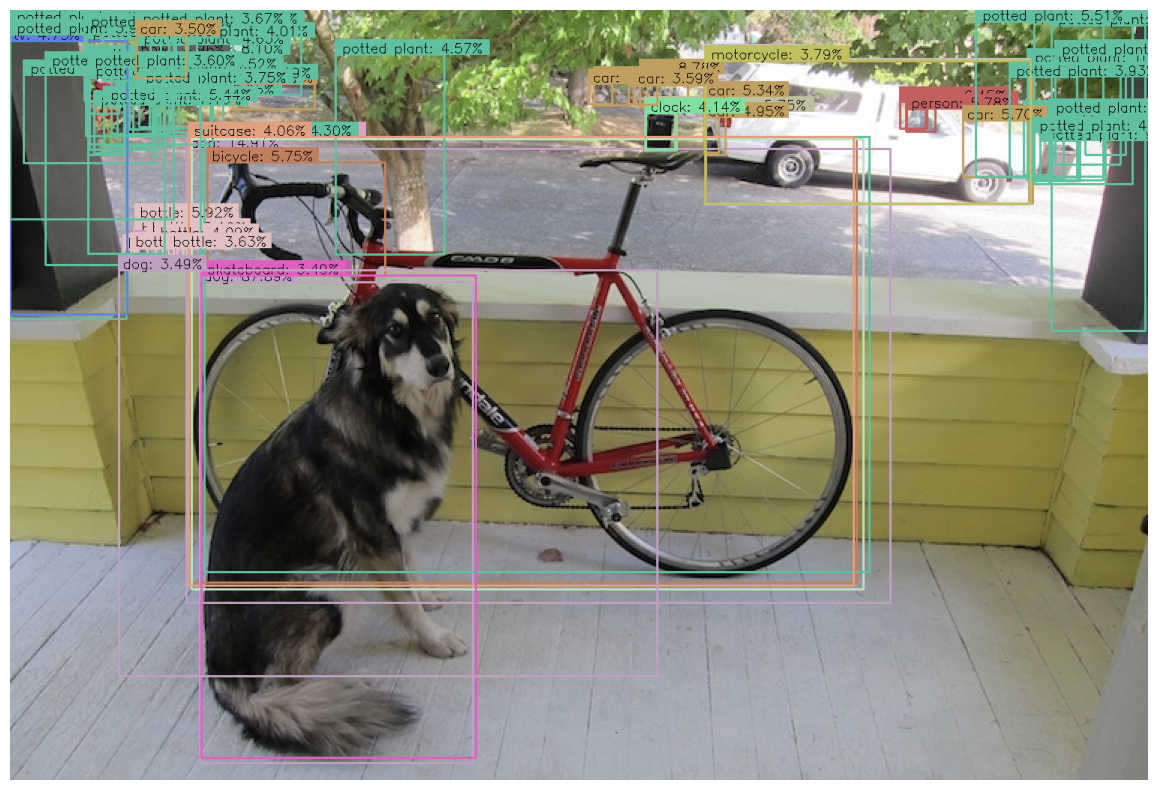

In [ ]:
# Call the model.
results = od_model(images[0])

# Convert the dictionary values to numpy arrays.
results = {key:value.numpy() for key, value in results.items()}

# Remove the batch dimension from the first image.
image = np.squeeze(images[0])

# Process the first sample image.
img_bbox = process_detection(image, results, min_det_thresh=0)

plt.figure(figsize=[15, 10])
plt.imshow(img_bbox)
plt.axis('off');

The results above show all the detections returned by the model since we did not apply a detection threshold to filter them. However, notice that all the mislabeled detections also have very low confidence.  It is always therefore recommended to apply a minimum detection threshold to the results generated by the model. The value of the threshold is something you need to experiment with depending on the data and the application, but generally, a value somewhere between 0.3 and 0.5 is a good rule of thumb.

### 2.2.3.2 Display Results with `min_det_thresh=0.3`

Let's now apply a detection threshold to filter the results.

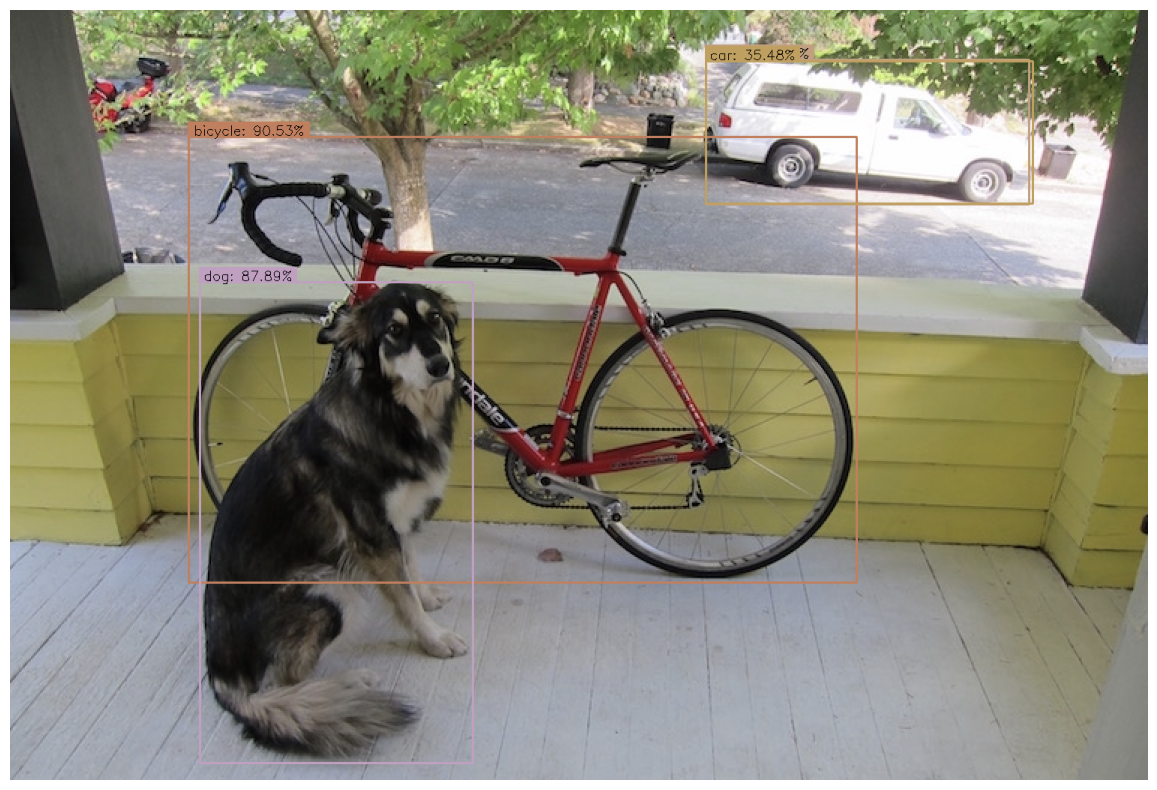

In [ ]:
img_bbox = process_detection(image, results, min_det_thresh=.3)

plt.figure(figsize=[15, 10])
plt.imshow(img_bbox)
plt.axis('off');

As shown above, a minimum detection threshold of 0.3 filters out all of the mislabeled deetctions. If you look closely, you will see there is one extra (redundant) detection of the car.

## 3 Formalize the Implementation

In this section we will formalize the implementation and create a convenience function to execute the model on a list of images. As noted in the documentation, the models in this family do not support "batching." This means we need to call the model once for each image. But note that the input shape for the image does require a batch dimension.

### 3.1 `run_inference()`

`run_inference()` is a helper function that will call the model for each image in the list of images.

In [ ]:
def run_inference(images, model):

    results_list = []
    for img in images:
        result = model(img)
        result = {key:value.numpy() for key,value in result.items()}

        results_list.append(result)

    return results_list

In [ ]:
# Perform inference on each image and store the results in a list.
results_list = run_inference(images, od_model)

Next, we loop over each of the images and use the results from the model to annotate a copy of the image, which is displayed to the console.

In [ ]:
for idx in range(len(images)):

    # Remove the batch dimension.
    image = np.squeeze(images[idx])

    # Generate the annotated image.
    image_bbox = process_detection(image, results_list[idx], min_det_thresh=.31)

    # Display annotated image.
    plt.figure(figsize=[20,10*len(images)])
    plt.subplot(len(images),1,idx+1)
    plt.imshow(image_bbox)
    plt.axis('off')

## 4 Conclusion

In this post, we covered how to use pre-trained object detection models available in TensorFlow Hub. TensorFlow Hub simplifies the process of reusing existing models by providing a central repository for sharing, discovering, and reusing pre-trained machine learning models. An essential aspect of working with these models involves interpreting their output. A key aspect of this is applying a detection threshold to filter the results generated by the model. Setting an appropriate detection threshold often requires experimentation and will also depend heavily on the type of application. In this example, we used the D4 model from the EfficienDet Family. However, if your application requires faster inference speeds, you should consider a smaller model (D0 to D3).

TensorFlow Hub Resources:

- [TensorFlow Hub Object Detection](https://www.tensorflow.org/hub/tutorials/tf2_object_detection)

- [Tensorflow Hub](https://www.tensorflow.org/hub)

- [Publishing models](https://www.tensorflow.org/hub/publish)
